Notebook for Nick Janick to explore and analyze the data as well as experiment with engineering features.

In [ ]:
# This first cell serves as an example and a base so we are starting with the same variable names and aliases
# I believe you should not need to redeclare variables or import statements in python cells that come after 
# this one, but I am still pretty new to working with notebooks so I could be wrong.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

'''
# this commented out block was used to split up data into seperate files for each season
# pulled new data sets for players for each season, one with combined teams for players who played for multiple teams and one with splits per team.
# using raw data as demonstration, once cleaned data file is ready comment next line out
player_data = '../../data/raw/raw_player_stats_2005-2025.csv' 
team_data = '../../data/raw/raw_team_stats_2005-2025.csv' 

# filtering down some of the data for the player stats and then splitting it into 3 seperate files(2005-2014, 2015-2024 and 2005-2024)
players =  pd.read_csv(player_data)
players = players.query("PA > 0 and Season >= 2015")
players.dtypes
players.dropna


teams = pd.read_csv(team_data)
# used this to split team stats into seperate files for each season
for season, season_df in teams.groupby("Season"):
    season_df.to_csv(f"../../data/raw/team_stats_{season}.csv", index=False)
'''


##Team Factor Feature

This proposed feature will theoretically help to account for how a players home field affects the number of homeruns a player may hit. Formula to calculate it will be:


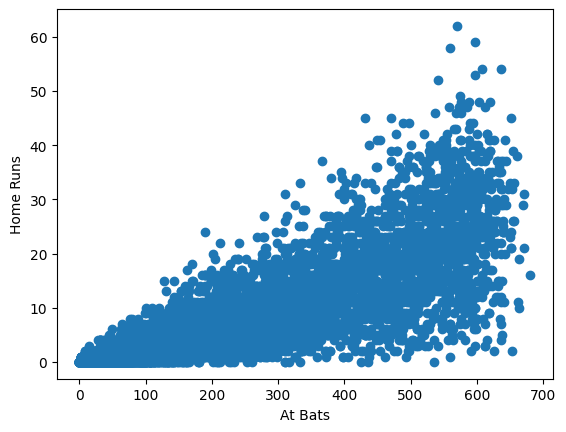

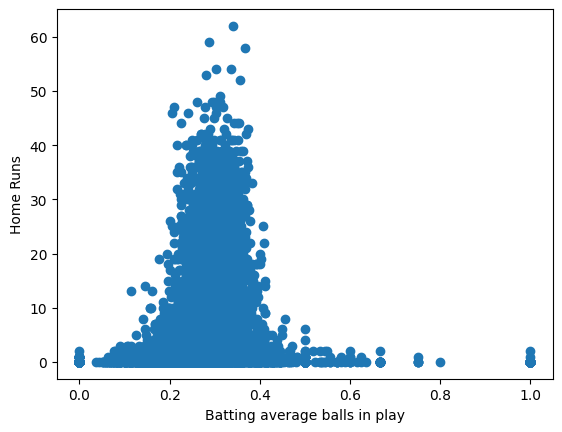

In [7]:
plt.scatter(players["BABIP"], players["HR"])
plt.xlabel("Batting average balls in play")
plt.ylabel("Home Runs")
plt.show()

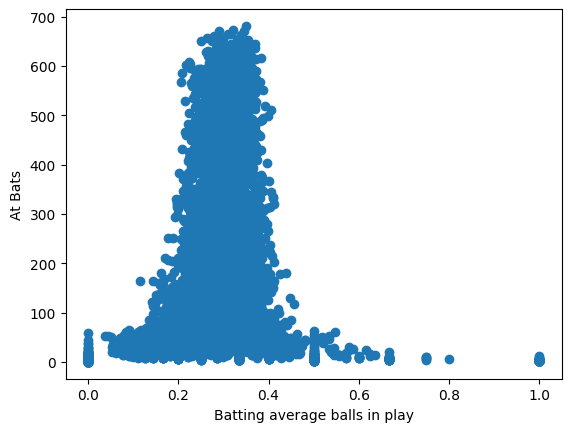

In [8]:
plt.scatter(players["BABIP"], players["AB"])
plt.xlabel("Batting average balls in play")
plt.ylabel("At Bats")
plt.show()

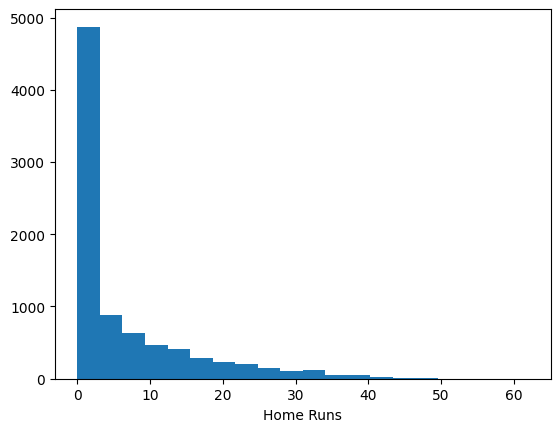

In [9]:
plt.hist(players["HR"],20)
plt.xlabel("Home Runs")
plt.show()

# Building a team factor function 
team_stats = pd.read_csv()